# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

### 1. Cleaning and Visualizations

In [53]:
import pandas as pd

df = pd.read_csv("/Users/leyakappukattil/Documents/Spr24-25/DS3001/linearModels/lab/data/cars_hw.csv")
df.head()


,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [54]:
df.drop(columns=['Unnamed: 0'], inplace=True)

df['Make_Year'] = df['Make_Year'].astype(int)
df['Mileage_Run'] = df['Mileage_Run'].astype(int)
df['Seating_Capacity'] = df['Seating_Capacity'].astype(int)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')  # handle weird values
df['No_of_Owners'] = df['No_of_Owners'].str.extract(r'(\d)').astype(float)

df.dropna(inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               976 non-null    object 
 1   Make_Year          976 non-null    int64  
 2   Color              976 non-null    object 
 3   Body_Type          976 non-null    object 
 4   Mileage_Run        976 non-null    int64  
 5   No_of_Owners       976 non-null    float64
 6   Seating_Capacity   976 non-null    int64  
 7   Fuel_Type          976 non-null    object 
 8   Transmission       976 non-null    object 
 9   Transmission_Type  976 non-null    object 
 10  Price              976 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 84.0+ KB


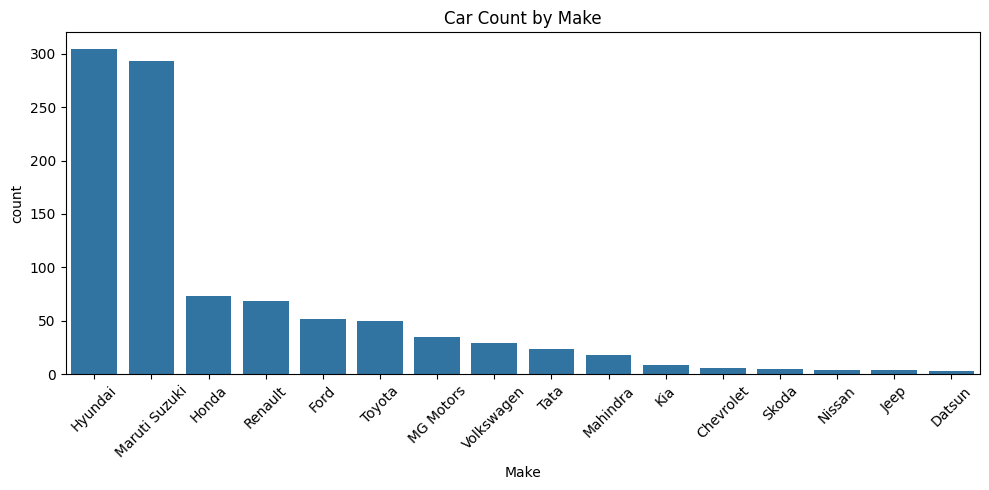

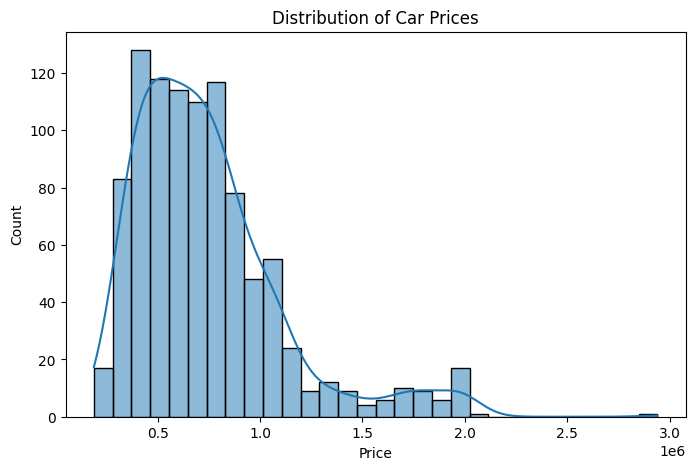

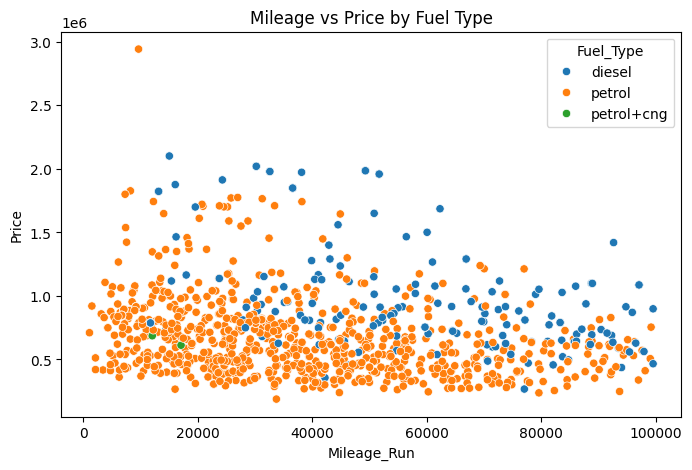

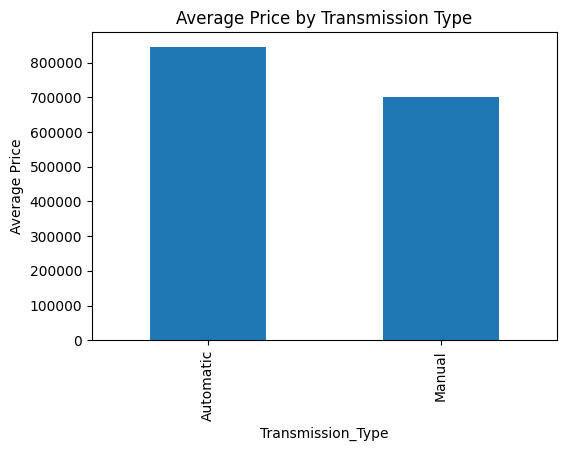

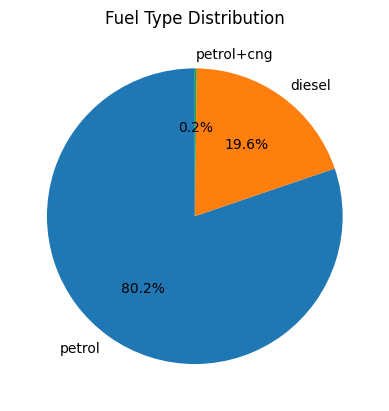

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

#a. Count of car brands
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Make', order=df['Make'].value_counts().index)
plt.title("Car Count by Make")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#b. Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.show()

#c. Mileage vs Price
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='Mileage_Run', y='Price', hue='Fuel_Type')
plt.title("Mileage vs Price by Fuel Type")
plt.show()

#d. Average Price by Transmission Type
plt.figure(figsize=(6,4))
df.groupby('Transmission_Type')['Price'].mean().plot(kind='bar')
plt.title("Average Price by Transmission Type")
plt.ylabel("Average Price")
plt.show()

#e. Fuel type pie chart
df['Fuel_Type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Fuel Type Distribution")
plt.ylabel("") 
plt.show()


### 2. Transform Variables

In [56]:
df_encoded = pd.get_dummies(df, columns=['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type'], drop_first=True)
print(df_encoded.columns)
print(df_encoded.head())


Index(['Make_Year', 'Mileage_Run', 'No_of_Owners', 'Seating_Capacity', 'Price',
       'Make_Datsun', 'Make_Ford', 'Make_Honda', 'Make_Hyundai', 'Make_Jeep',
       'Make_Kia', 'Make_MG Motors', 'Make_Mahindra', 'Make_Maruti Suzuki',
       'Make_Nissan', 'Make_Renault', 'Make_Skoda', 'Make_Tata', 'Make_Toyota',
       'Make_Volkswagen', 'Color_black', 'Color_blue', 'Color_bronze',
       'Color_brown', 'Color_golden', 'Color_green', 'Color_grey',
       'Color_maroon', 'Color_orange', 'Color_purple', 'Color_red',
       'Color_silver', 'Color_white', 'Color_yellow', 'Body_Type_hatchback',
       'Body_Type_muv', 'Body_Type_sedan', 'Body_Type_suv', 'Fuel_Type_petrol',
       'Fuel_Type_petrol+cng', 'Transmission_5-Speed', 'Transmission_6-Speed',
       'Transmission_7-Speed', 'Transmission_CVT', 'Transmission_Type_Manual'],
      dtype='object')
   Make_Year  Mileage_Run  No_of_Owners  Seating_Capacity   Price  \
0       2017        44611           1.0                 5  657000   
1   

In [57]:
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']


### 3. Implement an ~80/~20 train-test split. Put the test data aside.


In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training features: {X_train.shape}")
print(f"Training target:   {y_train.shape}")
print(f"Test features:     {X_test.shape}")
print(f"Test target:       {y_test.shape}")


Training features: (780, 44)
Training target:   (780,)
Test features:     (196, 44)
Test target:       (196,)


#### 4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

model_all = LinearRegression()
model_all.fit(X_train, y_train)

train_preds = model_all.predict(X_train)
test_preds = model_all.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Full Model:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE:  {test_rmse:.2f}")
print(f"Train R^2:  {train_r2:.4f}")
print(f"Test R^2:   {test_r2:.4f}")


Full Model:
Train RMSE: 142154.19
Test RMSE:  143815.30
Train R^2:  0.8552
Test R^2:   0.8197


The full linear model, which included all predictors without transformations or interactions, achieved a training RMSE of ₹142,154 and a test RMSE of ₹143,815. Its $R^2$ values were 0.8552 on the training set and 0.8197 on the test set, indicating strong performance with minimal overfitting. Among the models tested, this full model performed the best, effectively balancing accuracy and generalization.


### 5. Make partial correlation plots for each of the numeric variables in your model.

In [60]:
X_train_fixed = X_train.copy()
X_train_fixed = X_train_fixed.astype(float) 
X_train_const = sm.add_constant(X_train_fixed)
y_train_fixed = pd.to_numeric(y_train, errors='coerce')


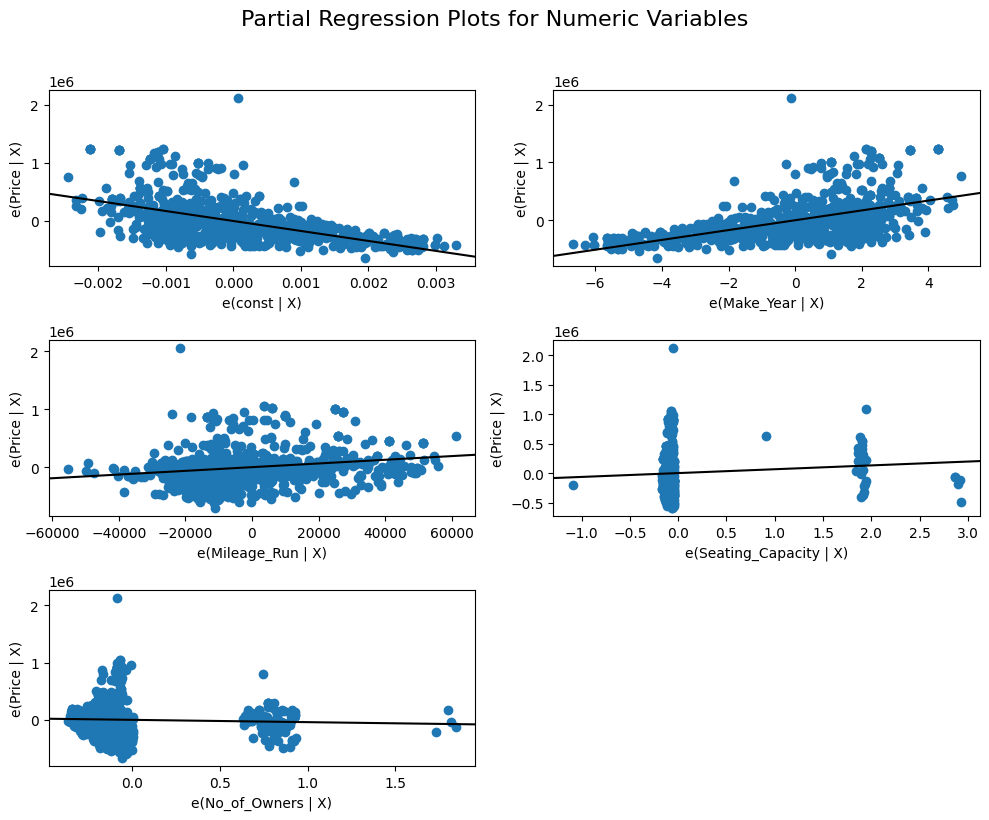

In [61]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

num_vars = ['Make_Year', 'Mileage_Run', 'Seating_Capacity', 'No_of_Owners']
X_num = X_train[num_vars].astype(float)
y_num = y_train.astype(float)

X_num_const = sm.add_constant(X_num)

model_num = sm.OLS(y_num, X_num_const).fit()

fig = plt.figure(figsize=(10, 8))
sm.graphics.plot_partregress_grid(model_num, fig=fig)

plt.suptitle("Partial Regression Plots for Numeric Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Do you notice any significant non-linearities? 
Yes, there are a few signs of potential non-linearities in the partial regression plots. The plot for `Make_Year` shows a relatively clear positive linear trend, suggesting a strong and appropriate linear relationship. However, `Mileage_Run` shows some spread and curvature, indicating a possible non-linear effect. `Seating_Capacity` and `No_of_Owners` appear more clustered and discrete, with limited variation and weaker linear patterns, which may reduce their predictive power or suggest they interact with other features. Overall, `Make_Year` is the most linear, while others may benefit from transformation or interaction terms in future models.


#### 6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets.

In [62]:
import numpy as np

X_transformed = X.copy()

X_transformed['Mileage_Run_squared'] = X_transformed['Mileage_Run'] ** 2
X_transformed['log_Mileage_Run'] = np.log(X_transformed['Mileage_Run'] + 1)  # add 1 to avoid log(0)

X_transformed['Year_Mileage'] = X_transformed['Make_Year'] * X_transformed['Mileage_Run']
X_transformed['Seating_Owners'] = X_transformed['Seating_Capacity'] * X_transformed['No_of_Owners']


In [63]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)


In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model_complex = LinearRegression()
model_complex.fit(X_train2, y_train2)

train_preds2 = model_complex.predict(X_train2)
test_preds2 = model_complex.predict(X_test2)

train_rmse2 = np.sqrt(mean_squared_error(y_train2, train_preds2))
test_rmse2 = np.sqrt(mean_squared_error(y_test2, test_preds2))
train_r2_2 = r2_score(y_train2, train_preds2)
test_r2_2 = r2_score(y_test2, test_preds2)

print("Complex Model with Transformations and Interactions:")
print(f"Train RMSE: {train_rmse2:.2f}")
print(f"Test RMSE:  {test_rmse2:.2f}")
print(f"Train R^2:  {train_r2_2:.4f}")
print(f"Test R^2:   {test_r2_2:.4f}")


Complex Model with Transformations and Interactions:
Train RMSE: 140514.73
Test RMSE:  143777.94
Train R^2:  0.8585
Test R^2:   0.8198


### How does the more complex model your build compare to the simpler ones?

The more complex model, which included transformations and interaction terms, showed a slight improvement over the simpler model. The training RMSE decreased from 142,154 to 140,515, and the training $R^2$ improved from 0.8552 to 0.8585, indicating a better fit to the training data. On the test set, the RMSE and $R^2$ remained nearly identical to the simpler model, suggesting that the added complexity marginally improved the model’s performance without overfitting.

#### 7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
Through steps 1 to 6, I cleaned the data, explored it visually, and built both simple and more complex linear regression models. The simpler model performed well with a good balance of accuracy and generalization, while the more complex model slightly improved training performance without overfitting, as test performance remained stable. This suggests that while adding transformations and interactions can enhance model fit, it's important to monitor for diminishing returns and avoid unnecessary complexity — highlighting the balance between underfitting, overfitting, and thoughtful model selection.



### 8. Optional

In [65]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lasso = make_pipeline(StandardScaler(), Lasso(alpha=1000, max_iter=10000, random_state=42))

lasso.fit(X_train2, y_train2)

train_preds_lasso = lasso.predict(X_train2)
test_preds_lasso = lasso.predict(X_test2)

from sklearn.metrics import mean_squared_error, r2_score
train_rmse_lasso = np.sqrt(mean_squared_error(y_train2, train_preds_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test2, test_preds_lasso))
train_r2_lasso = r2_score(y_train2, train_preds_lasso)
test_r2_lasso = r2_score(y_test2, test_preds_lasso)

print("🔹 Lasso Model Performance:")
print(f"Train RMSE: {train_rmse_lasso:.2f}")
print(f"Test RMSE:  {test_rmse_lasso:.2f}")
print(f"Train R^2:  {train_r2_lasso:.4f}")
print(f"Test R^2:   {test_r2_lasso:.4f}")


🔹 Lasso Model Performance:
Train RMSE: 142459.65
Test RMSE:  143516.59
Train R^2:  0.8546
Test R^2:   0.8204


In [66]:
lasso_model = lasso.named_steps['lasso']
coef = pd.Series(lasso_model.coef_, index=X_train2.columns)

selected_features = coef[coef != 0]
print("\nSelected Features by Lasso:")
print(selected_features.sort_values(ascending=False))



Selected Features by Lasso:
Make_MG Motors              136702.827565
Make_Year                   124705.417361
Body_Type_suv                69048.803983
Transmission_6-Speed         49943.026320
Seating_Capacity             48894.690291
Make_Kia                     41638.656362
Transmission_7-Speed         37272.500220
log_Mileage_Run              36641.521690
Make_Skoda                   34401.405062
Make_Jeep                    26325.417782
Body_Type_sedan              24127.311499
Make_Tata                    19297.195122
Make_Hyundai                 18511.390862
Make_Toyota                  17271.673614
Make_Honda                   11115.296066
Color_blue                    9870.505048
Color_brown                   9015.282793
Color_black                   8986.884368
Color_red                     6231.776015
Color_white                   5882.729427
Transmission_CVT              3432.239308
Color_orange                  1999.996076
Color_grey                    1113.234748
Color